# Inputs

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import xgboost as xgb
import mlflow
import mlflow.pyfunc
from sklearn.metrics import recall_score, precision_score, roc_auc_score
import joblib
import joblib
import pandas as pd
import shap
import matplotlib.pyplot as plt

c:\Users\ferna\Documents\Repos\e2e_ml_pipeline\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
input_path = "../data/platinum/models/"
input_path_pqt = "../data/platinum/shap/"

output_path = "../data/platinum/"

Path(output_path).mkdir(parents=True, exist_ok=True)

In [3]:
xgb_model = joblib.load(input_path + "xgb/model.pkl")
xgb_x_train = pd.read_parquet(input_path_pqt + "xgb/x_train.parquet")
xgb_y_train = pd.read_parquet(input_path_pqt + "xgb/y_train.parquet")
xgb_x_test = pd.read_parquet(input_path_pqt + "xgb/x_test.parquet")
xgb_y_test = pd.read_parquet(input_path_pqt + "xgb/y_test.parquet")

svm_model = joblib.load(input_path + "svm/model.pkl")
svm_x_train = pd.read_parquet(input_path_pqt + "svm/x_train.parquet")
svm_y_train = pd.read_parquet(input_path_pqt + "svm/y_train.parquet")
svm_x_test = pd.read_parquet(input_path_pqt + "svm/x_test.parquet")
svm_y_test = pd.read_parquet(input_path_pqt + "svm/y_test.parquet")

knn_model = joblib.load(input_path + "knn/model.pkl")
knn_x_train = pd.read_parquet(input_path_pqt + "knn/x_train.parquet")
knn_y_train = pd.read_parquet(input_path_pqt + "knn/y_train.parquet")
knn_x_test = pd.read_parquet(input_path_pqt + "knn/x_test.parquet")
knn_y_test = pd.read_parquet(input_path_pqt + "knn/y_test.parquet")

# Processing

## SHAP

In [4]:
def export_shap_values_to_csv(model, x_train, x_test, output_path):
    # 1. Initialize the SHAP Explainer
    # Works for most tree-based models. For deep learning, use shap.DeepExplainer
    explainer = shap.Explainer(model, x_train)

    # 2. Calculate SHAP values for the test set
    # This creates an Explanation object containing the 'values'
    shap_values = explainer(x_test, check_additivity=False)

    # 3. Format the data for CSV
    # shap_values.values is a matrix of (observations, features)
    # We use x_test.columns to ensure the CSV headers match your features
    shap_df = pd.DataFrame(
        data=shap_values.values, 
        columns=x_test.columns, 
        index=x_test.index
    )

    shap.summary_plot(shap_values, xgb_x_test, show=False)
    plt.savefig(output_path+'summary_plot.png', bbox_inches='tight', dpi=300)
    plt.close()

    shap.plots.bar(shap_values, show=False)
    plt.savefig(output_path+'global_importance_bar.png', bbox_inches='tight', dpi=300)
    plt.close()

    shap_df.to_csv(output_path+'shap_values.csv', index=True)
    print(f"SHAP values successfully exported to {output_path}")

In [5]:
# xgb
export_shap_values_to_csv(xgb_model, xgb_x_train, xgb_x_test, output_path + "shap/xgb/")

100%|===================| 174689/174735 [09:02<00:00]        

SHAP values successfully exported to ../data/platinum/shap/xgb/


In [14]:
x_test_sampled = knn_x_test.sample(n=int(knn_x_test.shape[0]*0.001), random_state=42)

In [16]:
# knn
#export_shap_values_to_csv(knn_model, knn_x_train, knn_x_test, output_path + "shap/knn/")
background_data = shap.kmeans(knn_x_train, 10) # 10 summary points
explainer = shap.KernelExplainer(knn_model.predict_proba, background_data)

# 2. Calculate SHAP values
# Warning: This can be slow for KNN on large test sets!
shap_values = explainer.shap_values(x_test_sampled)

# 3. Handle the output format
# For classification, shap_values is a list (one array per class)
# Usually, we want the values for the 'positive' class (index 1)
if isinstance(shap_values, list):
    shap_values_to_export = shap_values[1] 
else:
    shap_values_to_export = shap_values

# Export to CSV
# Assuming shap_values is the 3D numpy array (174, 22, 2)
# We want [all rows, all features, class 1]
shap_values_to_export = shap_values[:, :, 1] 

# Now this will work because it's 2D (174, 22)
df_shap = pd.DataFrame(shap_values_to_export, columns=knn_x_test.columns)
df_shap.to_csv(output_path + "shap_values.csv", index=False)

100%|██████████| 174/174 [11:51<00:00,  4.09s/it]


In [20]:
df_shap.to_csv(output_path + "/shap/knn/shap_values.csv", index=False)
shap.summary_plot(shap_values, x_test_sampled, show=False)
plt.savefig(output_path+'/shap/knn/summary_plot.png', bbox_inches='tight', dpi=300)
plt.close()

# Use this instead of shap.plots.bar
shap.summary_plot(shap_values_to_export, x_test_sampled, plot_type="bar", show=False)

plt.savefig(output_path + '/shap/knn/global_importance_bar.png', bbox_inches='tight', dpi=300)
plt.close()

In [21]:
import shap
import matplotlib.pyplot as plt

# 1. Reconstruct the Explanation object
# Values: The 2D slice [rows, features] for the Anomaly class
# Data: The actual feature values from your sampled test set
# Feature_names: The column names from your energy dataset
exp = shap.Explanation(
    values=shap_values_to_export, 
    data=x_test_sampled.values, # Use .values to ensure it's a numpy array
    feature_names=x_test_sampled.columns
)

# 2. Generate the Beeswarm plot
# We use shap.plots.beeswarm for the modern API
shap.plots.beeswarm(exp, show=False)

# 3. Save the result
plt.savefig(output_path + '/shap/knn/knn_beeswarm_plot.png', bbox_inches='tight', dpi=300)
plt.close()

c:\Users\ferna\Documents\Repos\e2e_ml_pipeline\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\ferna\Documents\Repos\e2e_ml_pipeline\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\ferna\Documents\Repos\e2e_ml_pipeline\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
  1%|          | 1/100 [00:01<01:59,  1.20s/it]c:\Users\ferna\Documents\Repos\e2e_ml_pipeline\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\ferna\Documents\Repos

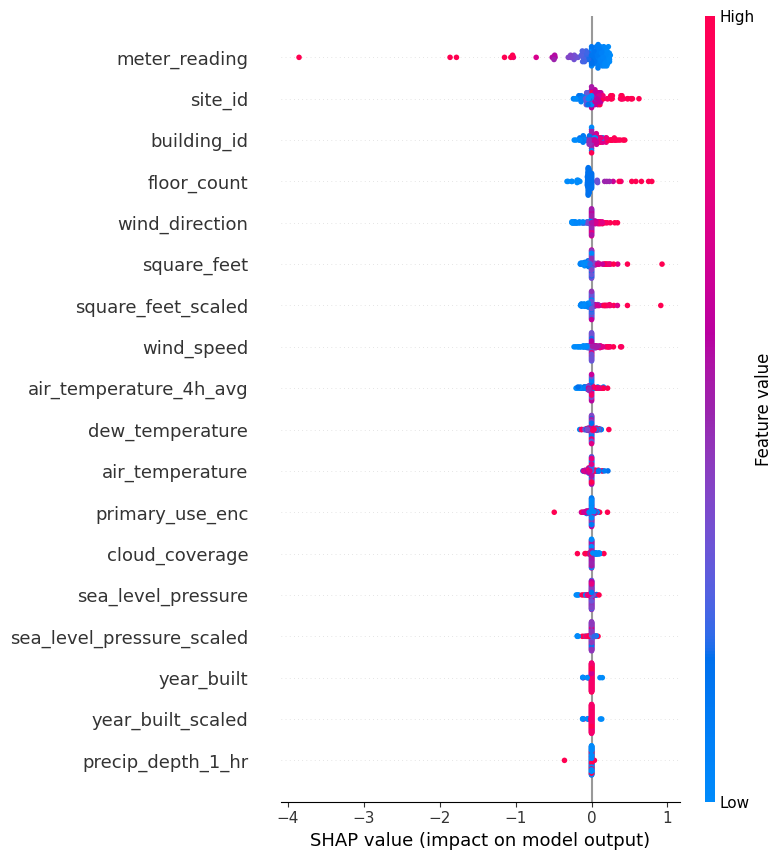

In [ ]:
# 1. Use a small background set to keep KernelExplainer fast
# (Using the whole svm_x_train with KernelExplainer is very slow)
background = shap.sample(svm_x_train, 7000) 

# 2. WRAP the decision function in a lambda
# This avoids the AttributeError by hiding the Pipeline's internal properties
model_func = lambda x: svm_model.decision_function(x)

# 3. Initialize the KernelExplainer
explainer = shap.KernelExplainer(model_func, background)

# 4. Calculate SHAP values (using a slice of test data if it's large)
# For KernelExplainer, every row takes significant time
shap_values = explainer.shap_values(svm_x_test)

# 5. Plot the Beeswax (Beeswarm) plot
shap.summary_plot(shap_values, svm_x_test)

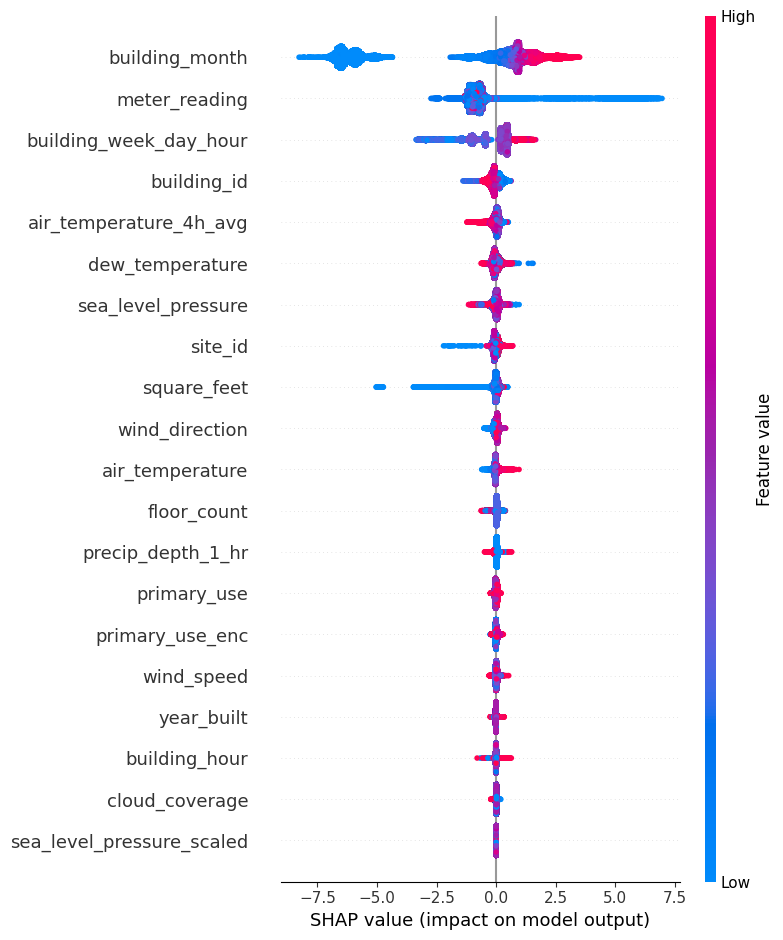

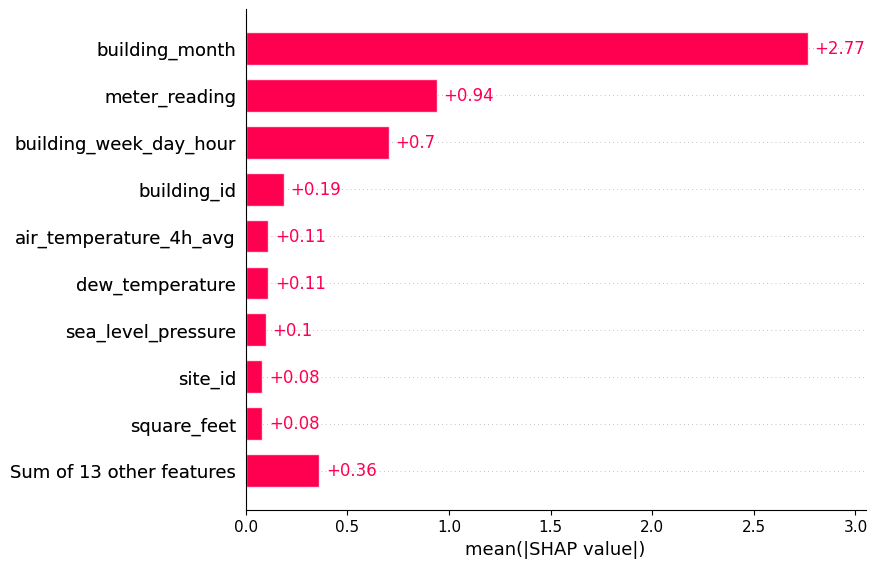

In [16]:
import matplotlib.pyplot as plt
import shap

# 1. Generate the plot without showing it immediately
shap.summary_plot(shap_values, xgb_x_test)
# 2. Save the figure to your specified path
# You can use .png, .pdf, or .svg
plt.savefig(output_path+'shap/summary_plot.png', bbox_inches='tight', dpi=300)

# 3. Clear the plot to avoid overlapping with the next one
plt.close()

# 1. Generate the bar plot
shap.plots.bar(shap_values)
# 2. Save the figure
plt.savefig(output_path+'shap/global_importance_bar.png', bbox_inches='tight', dpi=300)

# 3. Clear the plot
plt.close()

## Model comparsion

In [ ]:
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Load your models (assuming filenames)
svm_model = joblib.load(input_path + "svm/model.pkl")
knn_model = joblib.load(input_path + "knn/model.pkl")
xgb_model = joblib.load(input_path + "xgb/model.pkl")

# Define a dictionary for easy iteration
models = {
    'SVM': svm_model,
    'k-NN': knn_model,
    'XGBoost': xgb_model
}

# 2. Setup your test data
# X_test, y_test = ... (Ensure this is defined)

results = []

# 3. Iterate and evaluate
for name, model in models.items():
    if name == 'SVM':
        X_test = svm_x_test
        y_test = svm_y_test
    elif name == 'k-NN':
        X_test = knn_x_test
        y_test = knn_y_test
    elif name == 'XGBoost':
        X_test = xgb_x_test
        y_test = xgb_y_test
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted')
    }
    results.append(metrics)

# 4. Create Comparison Table
comparison_df = pd.DataFrame(results)

# Display the table
print("--- Model Performance Comparison ---")
print(comparison_df.to_string(index=False))

# 5. Export to CSV
comparison_df.to_csv('model_comparison_metrics.csv', index=False)
print("\nMetrics exported successfully to 'model_comparison_metrics.csv'")

c:\Users\ferna\Documents\Repos\e2e_ml_pipeline\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
